# Part 0: Import 套件

In [1]:
# 下載資料套件
import requests as r

#資料處理套件
import pandas as pd
import numpy as np
import json
from datetime import datetime, date

# 畫圖套件
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Part 1: 台股個股Ｋ線圖與成交量(成交股數)

## 1.1 下載台股個股歷史走勢資料
- 股海小英雄youtube影片：[【Python 爬蟲】台股個股資料免費下載｜選擇想要的個股資料！](https://youtu.be/_4CEymrQbV8)

In [2]:
def get_tw_stock_data(start_year, start_month, end_year, end_month, stock_code):
    start_date = str(date(start_year, start_month, 1))
    end_date = str(date(end_year, end_month, 1))
    month_list = pd.date_range(start_date, end_date, freq='MS').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for month in month_list:
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo=" + str(stock_code)
        res = r.get(url)
        stock_json = res.json()
        stock_df = pd.DataFrame.from_dict(stock_json['data'])
        df = df.append(stock_df, ignore_index = True)
        
    # 資料轉型
    for col in [0, 1, 2, 3, 4, 5, 6, 8]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)，並將民國年換成西元年
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]) + 1911, int(day[1]), int(day[2]))
            # 把"開盤價", "最高價", "最低價", "收盤價"帶有逗號的字串(string)換成浮點數(float) 
            elif col != 0:
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    df.columns = ['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']
    return df

In [3]:
#下載台股個股成交資訊 - 台積電:2330
df = get_tw_stock_data(start_year = 2021, 
                       start_month = 10, 
                       end_year = 2021, 
                       end_month = 10, 
                       stock_code = 2330)
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2021-10-01 00:00:00,39006124.0,22368447571.0,579.0,579.0,571.0,574.0,-6.00,78088.0
1,2021-10-04 00:00:00,22288138.0,12741914919.0,574.0,575.0,569.0,572.0,-2.00,42147.0
2,2021-10-05 00:00:00,36063650.0,20406526124.0,562.0,572.0,560.0,572.0,0.00,56678.0
3,2021-10-06 00:00:00,33989379.0,19345468774.0,573.0,574.0,565.0,571.0,-1.00,53606.0
4,2021-10-07 00:00:00,28480400.0,16458019782.0,575.0,582.0,572.0,580.0,+9.00,23304.0
5,2021-10-08 00:00:00,22601904.0,13051944932.0,582.0,583.0,573.0,575.0,-5.00,24157.0
6,2021-10-12 00:00:00,27126088.0,15455194493.0,570.0,575.0,564.0,575.0,0.00,32210.0
7,2021-10-13 00:00:00,19267437.0,11006807040.0,572.0,575.0,570.0,571.0,-4.00,18050.0
8,2021-10-14 00:00:00,14270641.0,8213170376.0,579.0,579.0,573.0,573.0,+2.00,14814.0
9,2021-10-15 00:00:00,55305252.0,32878638999.0,592.0,600.0,586.0,600.0,+27.00,61088.0


## 1.2 下載三大法人買賣超日報
- 股海小英雄youtube影片：[【Python 爬蟲】台股三大法人買賣超免費下載｜馬上看透法人買賣動向！](https://youtu.be/9TH92y0f_Mg)

In [4]:
def get_tw_investor_data(start_year, start_month, start_day, end_year, end_month, end_day, stock_code):
    start_date = str(date(start_year, start_month, start_day))
    end_date = str(date(end_year, end_month, end_day))

    date_list = pd.date_range(start_date, end_date, freq='D').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for day in date_list:
        url = 'https://www.twse.com.tw/fund/T86?response=json&date=' + day + '&selectType=24' #selectType=ALL
        res = r.get(url)
        inv_json = res.json()
        if res.json()['stat'] == '很抱歉，沒有符合條件的資料!':
            continue
        else:
            df_inv = pd.DataFrame.from_dict(inv_json['data'])
            df_inv.insert(0, '日期', datetime(int(day[:4]), int(day[4:6]), int(day[6:])))
            df = df.append(df_inv, ignore_index = True)
     
    df.columns = ['日期', '證券代號', '證券名稱', '外陸資買進股數(不含外資自營商)', '外陸資賣出股數(不含外資自營商)', '外陸資買賣超股數(不含外資自營商)', '外資自營商買進股數', '外資自營商賣出股數', '外資自營商買賣超股數', '投信買進股數', '投信賣出股數', '投信買賣超股數', '自營商買賣超股數', '自營商買進股數(自行買賣)', '自營商賣出股數(自行買賣)', '自營商買賣超股數(自行買賣)', '自營商買進股數(避險)', '自營商賣出股數(避險)', '自營商買賣超股數(避險)', '三大法人買賣超股數']
    
    # 資料轉型
    for col in range(3, 20):
        for row in range(df.shape[0]):
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    # 加入股票代碼篩選
    if stock_code == None:
        pass
    else:
        df = df[df['證券代號'] == str(stock_code)]
    
    return df

In [5]:
#下載台股三大法人買賣超 - 台積電:2330
df_inv = get_tw_investor_data(start_year = 2021, 
                              start_month = 10, 
                              start_day = 1, 
                              end_year = 2021, 
                              end_month = 10, 
                              end_day = 22, 
                              stock_code = 2330)
df_inv

,日期,證券代號,證券名稱,外陸資買進股數(不含外資自營商),外陸資賣出股數(不含外資自營商),外陸資買賣超股數(不含外資自營商),外資自營商買進股數,外資自營商賣出股數,外資自營商買賣超股數,投信買進股數,投信賣出股數,投信買賣超股數,自營商買賣超股數,自營商買進股數(自行買賣),自營商賣出股數(自行買賣),自營商買賣超股數(自行買賣),自營商買進股數(避險),自營商賣出股數(避險),自營商買賣超股數(避險),三大法人買賣超股數
72,2021-10-01,2330,台積電,12910215.0,26273043.0,-13362828.0,0.0,0.0,0.0,699000.0,0.0,699000.0,-516700.0,228000.0,1336435.0,-1108435.0,1048000.0,456265.0,591735.0,-13180528.0
145,2021-10-04,2330,台積電,8775773.0,13708108.0,-4932335.0,0.0,0.0,0.0,942727.0,0.0,942727.0,640869.0,343848.0,593000.0,-249152.0,980000.0,89979.0,890021.0,-3348739.0
220,2021-10-05,2330,台積電,12249281.0,29511485.0,-17262204.0,0.0,0.0,0.0,1100000.0,15000.0,1085000.0,1534230.0,887998.0,163795.0,724203.0,921000.0,110973.0,810027.0,-14642974.0
291,2021-10-06,2330,台積電,19806322.0,25314100.0,-5507778.0,0.0,0.0,0.0,751000.0,80000.0,671000.0,-1060984.0,310998.0,1931648.0,-1620650.0,626000.0,66334.0,559666.0,-5897762.0
300,2021-10-07,2330,台積電,18867085.0,18002337.0,864748.0,0.0,0.0,0.0,297000.0,112000.0,185000.0,2014868.0,1535016.0,339886.0,1195130.0,839289.0,19551.0,819738.0,3064616.0
434,2021-10-08,2330,台積電,14959667.0,18485905.0,-3526238.0,0.0,0.0,0.0,142000.0,16000.0,126000.0,87750.0,267998.0,174993.0,93005.0,96000.0,101255.0,-5255.0,-3312488.0
510,2021-10-12,2330,台積電,13672748.0,19455225.0,-5782477.0,0.0,0.0,0.0,498636.0,23000.0,475636.0,-505976.0,353115.0,889986.0,-536871.0,241096.0,210201.0,30895.0,-5812817.0
581,2021-10-13,2330,台積電,9409824.0,14659095.0,-5249271.0,0.0,0.0,0.0,761636.0,256000.0,505636.0,827668.0,805000.0,117586.0,687414.0,162000.0,21746.0,140254.0,-3915967.0
602,2021-10-14,2330,台積電,8184100.0,8409660.0,-225560.0,0.0,0.0,0.0,316636.0,3000.0,313636.0,466893.0,449993.0,419100.0,30893.0,457000.0,21000.0,436000.0,554969.0
658,2021-10-15,2330,台積電,42409941.0,8672334.0,33737607.0,0.0,0.0,0.0,314636.0,20000.0,294636.0,591491.0,1205989.0,552000.0,653989.0,366502.0,429000.0,-62498.0,34623734.0


# Part 2: 畫出個股Ｋ線圖與三大法人買賣超
## 2.1: 畫個股Ｋ線圖與三大法人買賣超
股海小英雄youtube影片：
- [【股市分析】用K線預測大盤趨勢｜最好用Python套件分享](https://youtu.be/FX6YAyOdEaE)
- [【股市分析】從K線與成交量看出盤勢｜用Python畫K線與成交量](https://youtu.be/jVADPj3SAXQ)

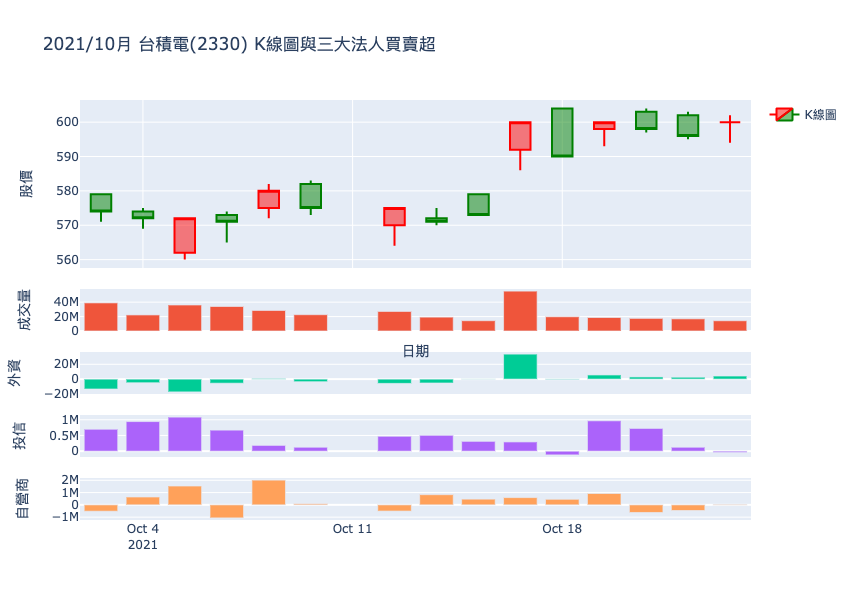

In [12]:
# 設定子圖
fig = make_subplots(rows = 5, 
                    cols = 1, 
                    shared_xaxes = True, 
                    vertical_spacing = 0.05,  
                    row_width=[0.1, 0.1, 0.1, 0.1, 0.4])

# 圖一：畫個股Ｋ線圖
fig.add_trace(go.Candlestick(x = df['日期'], 
                             open = df['開盤價'], 
                             high = df['最高價'],
                             low = df['最低價'], 
                             close = df['收盤價'], 
                             increasing_line_color = 'red', 
                             decreasing_line_color = 'green',
                             name = 'K線圖'), 
              row = 1, 
              col = 1)
 
# 圖二：畫成交量長條圖
fig.add_trace(go.Bar(x = df['日期'], 
                     y = df['成交股數'], 
                     showlegend = False,
                     name = '成交股數'), 
              row = 2, 
              col = 1)


# 圖三：畫外資買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['外陸資買賣超股數(不含外資自營商)'], 
                     showlegend = False,
                     name = '外資買賣超成交量'), 
              row = 3, 
              col = 1)

# 圖四：畫投信買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['投信買賣超股數'], 
                     showlegend = False,
                     name = '投信買賣超成交量'), 
              row = 4, 
              col = 1)

# 圖五：畫自營商買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['自營商買賣超股數'], 
                     showlegend = False,
                     name = '自營商買賣超成交量'), 
              row = 5, 
              col = 1)

# 設x軸標題
fig.update_xaxes(rangebreaks = [{ 'pattern': 'day of week', 'bounds': [6, 1]}])
fig.update_xaxes(title_text = "日期", row = 2, col = 1)

# 設y軸標題
fig.update_yaxes(title_text = "股價", row = 1, col = 1)
fig.update_yaxes(title_text = "成交量", row = 2, col = 1)
fig.update_yaxes(title_text = "外資", row = 3, col = 1)
fig.update_yaxes(title_text = "投信", row = 4, col = 1)
fig.update_yaxes(title_text = "自營商", row = 5, col = 1)

# 設圖標及圖長寬
fig.update_layout(
    title_text = "2021/10月 台積電(2330) K線圖與三大法人買賣超",
    width = 800,
    height = 600
)

fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()

## 2.2: 設定成交量顏色(依K棒顏色)

In [7]:
df["成交量顏色"] = np.where(df["開盤價"] <= df["收盤價"], 'red', 'green')
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,成交量顏色
0,2021-10-01 00:00:00,39006124.0,22368447571.0,579.0,579.0,571.0,574.0,-6.00,78088.0,green
1,2021-10-04 00:00:00,22288138.0,12741914919.0,574.0,575.0,569.0,572.0,-2.00,42147.0,green
2,2021-10-05 00:00:00,36063650.0,20406526124.0,562.0,572.0,560.0,572.0,0.00,56678.0,red
3,2021-10-06 00:00:00,33989379.0,19345468774.0,573.0,574.0,565.0,571.0,-1.00,53606.0,green
4,2021-10-07 00:00:00,28480400.0,16458019782.0,575.0,582.0,572.0,580.0,+9.00,23304.0,red
5,2021-10-08 00:00:00,22601904.0,13051944932.0,582.0,583.0,573.0,575.0,-5.00,24157.0,green
6,2021-10-12 00:00:00,27126088.0,15455194493.0,570.0,575.0,564.0,575.0,0.00,32210.0,red
7,2021-10-13 00:00:00,19267437.0,11006807040.0,572.0,575.0,570.0,571.0,-4.00,18050.0,green
8,2021-10-14 00:00:00,14270641.0,8213170376.0,579.0,579.0,573.0,573.0,+2.00,14814.0,green
9,2021-10-15 00:00:00,55305252.0,32878638999.0,592.0,600.0,586.0,600.0,+27.00,61088.0,red


## 2.3: 設定三大法人買賣超顏色(依正負)

In [8]:
df_inv["外資買賣超顏色"] = np.where(df_inv["外陸資買賣超股數(不含外資自營商)"] >= 0, 'red', 'green')
df_inv["投信買賣超顏色"] = np.where(df_inv["投信買賣超股數"] >= 0, 'red', 'green')
df_inv["自營商買賣超顏色"] = np.where(df_inv["自營商買賣超股數"] >= 0, 'red', 'green')
df_inv

,日期,證券代號,證券名稱,外陸資買進股數(不含外資自營商),外陸資賣出股數(不含外資自營商),外陸資買賣超股數(不含外資自營商),外資自營商買進股數,外資自營商賣出股數,外資自營商買賣超股數,投信買進股數,...,自營商買進股數(自行買賣),自營商賣出股數(自行買賣),自營商買賣超股數(自行買賣),自營商買進股數(避險),自營商賣出股數(避險),自營商買賣超股數(避險),三大法人買賣超股數,外資買賣超顏色,投信買賣超顏色,自營商買賣超顏色
72,2021-10-01,2330,台積電,12910215.0,26273043.0,-13362828.0,0.0,0.0,0.0,699000.0,...,228000.0,1336435.0,-1108435.0,1048000.0,456265.0,591735.0,-13180528.0,green,red,green
145,2021-10-04,2330,台積電,8775773.0,13708108.0,-4932335.0,0.0,0.0,0.0,942727.0,...,343848.0,593000.0,-249152.0,980000.0,89979.0,890021.0,-3348739.0,green,red,red
220,2021-10-05,2330,台積電,12249281.0,29511485.0,-17262204.0,0.0,0.0,0.0,1100000.0,...,887998.0,163795.0,724203.0,921000.0,110973.0,810027.0,-14642974.0,green,red,red
291,2021-10-06,2330,台積電,19806322.0,25314100.0,-5507778.0,0.0,0.0,0.0,751000.0,...,310998.0,1931648.0,-1620650.0,626000.0,66334.0,559666.0,-5897762.0,green,red,green
300,2021-10-07,2330,台積電,18867085.0,18002337.0,864748.0,0.0,0.0,0.0,297000.0,...,1535016.0,339886.0,1195130.0,839289.0,19551.0,819738.0,3064616.0,red,red,red
434,2021-10-08,2330,台積電,14959667.0,18485905.0,-3526238.0,0.0,0.0,0.0,142000.0,...,267998.0,174993.0,93005.0,96000.0,101255.0,-5255.0,-3312488.0,green,red,red
510,2021-10-12,2330,台積電,13672748.0,19455225.0,-5782477.0,0.0,0.0,0.0,498636.0,...,353115.0,889986.0,-536871.0,241096.0,210201.0,30895.0,-5812817.0,green,red,green
581,2021-10-13,2330,台積電,9409824.0,14659095.0,-5249271.0,0.0,0.0,0.0,761636.0,...,805000.0,117586.0,687414.0,162000.0,21746.0,140254.0,-3915967.0,green,red,red
602,2021-10-14,2330,台積電,8184100.0,8409660.0,-225560.0,0.0,0.0,0.0,316636.0,...,449993.0,419100.0,30893.0,457000.0,21000.0,436000.0,554969.0,green,red,red
658,2021-10-15,2330,台積電,42409941.0,8672334.0,33737607.0,0.0,0.0,0.0,314636.0,...,1205989.0,552000.0,653989.0,366502.0,429000.0,-62498.0,34623734.0,red,red,red


## 2.4: 畫個股Ｋ線圖與三大法人買賣超(含顏色)

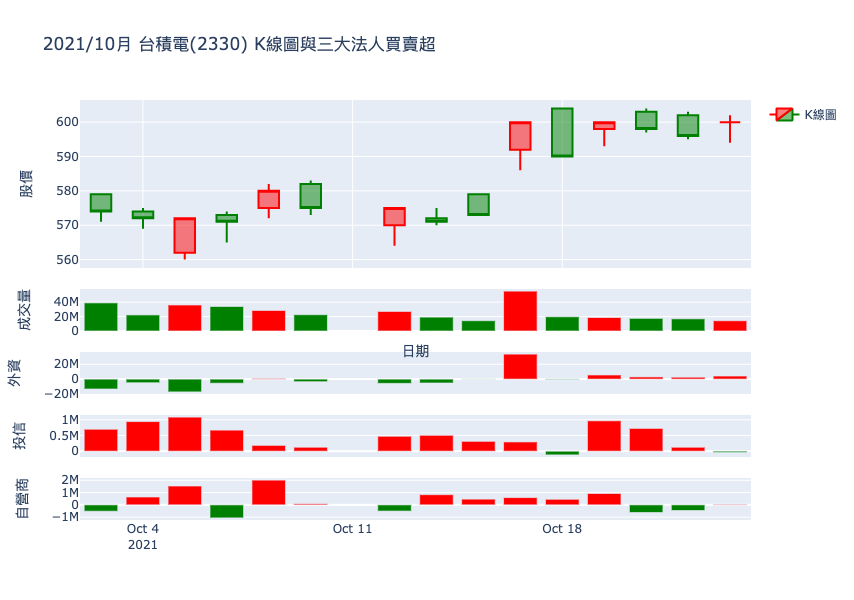

In [13]:
# 設定子圖
fig = make_subplots(rows = 5, 
                    cols = 1, 
                    shared_xaxes = True, 
                    vertical_spacing = 0.05,  
                    row_width=[0.1, 0.1, 0.1, 0.1, 0.4])

# 圖一：畫個股Ｋ線圖
fig.add_trace(go.Candlestick(x = df['日期'], 
                             open = df['開盤價'], 
                             high = df['最高價'],
                             low = df['最低價'], 
                             close = df['收盤價'], 
                             increasing_line_color = 'red', 
                             decreasing_line_color = 'green',
                             name = 'K線圖'), 
              row = 1, 
              col = 1)
 
# 圖二：畫成交量長條圖
fig.add_trace(go.Bar(x = df['日期'], 
                     y = df['成交股數'], 
                     showlegend = False,
                     name = '成交股數',
                     marker_color = df['成交量顏色']), 
              row = 2, 
              col = 1)


# 圖三：畫外資買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['外陸資買賣超股數(不含外資自營商)'], 
                     showlegend = False,
                     name = '外資買賣超成交量',
                     marker_color = df_inv['外資買賣超顏色']), 
              row = 3, 
              col = 1)

# 圖四：畫投信買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['投信買賣超股數'], 
                     showlegend = False,
                     name = '投信買賣超成交量',
                     marker_color = df_inv['投信買賣超顏色']), 
              row = 4, 
              col = 1)

# 圖五：畫自營商買賣超成交量
fig.add_trace(go.Bar(x = df_inv['日期'], 
                     y = df_inv['自營商買賣超股數'], 
                     showlegend = False,
                     name = '自營商買賣超成交量',
                     marker_color = df_inv['自營商買賣超顏色']), 
              row = 5, 
              col = 1)


# 設x軸標題
fig.update_xaxes(rangebreaks = [{ 'pattern': 'day of week', 'bounds': [6, 1]}])
fig.update_xaxes(title_text = "日期", row = 2, col = 1)

# 設y軸標題
fig.update_yaxes(title_text = "股價", row = 1, col = 1)
fig.update_yaxes(title_text = "成交量", row = 2, col = 1)
fig.update_yaxes(title_text = "外資", row = 3, col = 1)
fig.update_yaxes(title_text = "投信", row = 4, col = 1)
fig.update_yaxes(title_text = "自營商", row = 5, col = 1)

# 設圖標及圖長寬
fig.update_layout(
    title_text = "2021/10月 台積電(2330) K線圖與三大法人買賣超",
    width = 800,
    height = 600
)

fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()